In [15]:
import pandas as pd
import numpy as np

In [755]:
vt = pd.read_csv('vitals_trajectory.csv')

<ipython-input-755-64f1363dbd35>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  vt = pd.read_csv('vitals_trajectory.csv')


## Filter  & standardization
MODS=1 on Day1, minute to hour and other cleaning

In [756]:
# drop completely redundant rows and keep MODS=day1 patients
all_sp = vt.drop('event_units',axis = 1).drop_duplicates()
mods_day1 = all_sp[all_sp['mods_day1']==1].drop('mods_day1',axis = 1)

In [757]:
# convert time from min to hour, reorder dataframe and clean age_group notation
mods_day1['event_hour'] = mods_day1['event_time'].div(60)
mods_day1['died_hour'] = mods_day1['died_time'].div(60)
mods_day1 = mods_day1.sort_values(by=['hospital_id','age_group','EncID','event_time','event_name'])
mods_day1['age_group'] = [i.split('.')[1] for i in mods_day1['age_group'].tolist()]
mods_day1

,EncID,hospital_id,age_group,mods_day7,died_in_hosp,died_time,event_name,event_time,event_value,event_hour,died_hour
377547,10236 L2_P01,P01,1 mo,0,0,NaN,PULSE,4.0,169.0,0.066667,NaN
645780,10236 L2_P01,P01,1 mo,0,0,NaN,PULSE_OX,4.0,99.0,0.066667,NaN
771672,10236 L2_P01,P01,1 mo,0,0,NaN,RESP_RATE,4.0,47.0,0.066667,NaN
995554,10236 L2_P01,P01,1 mo,0,0,NaN,TEMP,4.0,36.5,0.066667,NaN
377548,10236 L2_P01,P01,1 mo,0,0,NaN,PULSE,9.0,168.0,0.150000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5163515,990_P13,P13,144 to 216 mo,0,0,NaN,MAP,1434.0,68.0,23.900000,NaN
5057237,990_P13,P13,144 to 216 mo,0,0,NaN,PULSE,1434.0,96.0,23.900000,NaN
5299321,990_P13,P13,144 to 216 mo,0,0,NaN,PULSE_OX,1434.0,100.0,23.900000,NaN
5524450,990_P13,P13,144 to 216 mo,0,0,NaN,RESP_RATE,1434.0,26.0,23.900000,NaN


## Population characteristics

In [758]:
# number of MODS=1 on day 1 versus all patients
print(mods_day1['EncID'].nunique(), all_sp['EncID'].nunique())

12845 38398


In [759]:
# mods day 7 difference between mods on day1 and all patients
print(mods_day1.groupby('EncID').first()['mods_day7'].value_counts(normalize=True), all_sp.groupby('EncID').first()['mods_day7'].value_counts(normalize=True), sep='\n')

0    0.710315
1    0.289685
Name: mods_day7, dtype: float64
0    0.883119
1    0.116881
Name: mods_day7, dtype: float64


In [760]:
# death in hospital difference
print(mods_day1.groupby('EncID').first()['died_in_hosp'].value_counts(normalize=True), all_sp.groupby('EncID').first()['died_in_hosp'].value_counts(normalize=True), sep='\n')

0    0.892254
1    0.107746
Name: died_in_hosp, dtype: float64
0    0.953018
1    0.046982
Name: died_in_hosp, dtype: float64


In [761]:
# death in hospital count difference
print(mods_day1.groupby('EncID').first()['died_in_hosp'].value_counts(), all_sp.groupby('EncID').first()['died_in_hosp'].value_counts(), sep='\n')

0    11461
1     1384
Name: died_in_hosp, dtype: int64
0    36594
1     1804
Name: died_in_hosp, dtype: int64


In [762]:
# proportion in each group for mods day1
mods_day1.groupby('EncID').first()['age_group'].value_counts(normalize=True)

 60 to 143 mo     0.254885
 144 to 216 mo    0.242507
 2 to 11 mo       0.175710
 24 to 59 mo      0.170027
 12 to 24 mo      0.116388
 1 mo             0.040483
Name: age_group, dtype: float64

## Clean death time
replace negative values with last vital time

In [763]:
# replace negative death times with time of last vital
tmp = mods_day1.groupby('EncID').last()
last_event_time = tmp[tmp['died_time']<0][['event_time','event_hour']]
neg_death_id = last_event_time.index.tolist()
neg_death_time = last_event_time['event_time'].tolist()
neg_death_hr = last_event_time['event_hour'].tolist()
for idx,val in enumerate(neg_death):
    #print(mods_day1.loc[mods_day1.index ==val, 'died_time'])
    mods_day1.loc[mods_day1['EncID'] ==val, 'died_time'] = neg_death_time[idx]
    mods_day1.loc[mods_day1['EncID'] ==val, 'died_hour'] = neg_death_hr[idx]

In [764]:
mods_day1.groupby('EncID').first()['died_hour'].describe()

count     1520.000000
mean      1575.226939
std       4737.358347
min          0.000000
25%         45.800000
50%        151.750000
75%        746.533333
max      45330.333333
Name: died_hour, dtype: float64

In [765]:
mods_day1 = mods_day1.drop(['event_time','died_time'],axis = 1)

## Select first 12hr of vitals

In [766]:
#mods_day1.to_csv('mods_day1.csv',index=False)
mods_day1_12hr = mods_day1[mods_day1['event_hour']<13]
#mods_day1_12hr.to_csv('mods_day1_12hr.csv',index=False)

In [767]:
# available vitals in first 12 hours
mods_day1_12hr['event_name'].value_counts()

PULSE        346133
PULSE_OX     341325
MAP          340268
SBP          328342
RESP_RATE    314790
FIO2         168956
TEMP         134148
SF_RATIO     103497
Name: event_name, dtype: int64

## Re-calculate SF Ratio
Hourly SF ratio = hourly average of pulse_ox / hourly average of fio2

In [768]:
# re-derive sf_ratio - mean method
sf_ratio = mods_day1_12hr[mods_day1_12hr['event_name'].isin(['PULSE_OX','FIO2','SF_RATIO'])][['EncID','event_name','event_hour','event_value']]
sf_ratio['event_hr_floor'] = np.floor(sf_ratio['event_hour'])
pulse_ox_df = sf_ratio[sf_ratio['event_name'] == 'PULSE_OX']
fio2_df = sf_ratio[sf_ratio['event_name'] == 'FIO2']
pulse_ox_ave = pd.DataFrame(pulse_ox_df .groupby(['EncID','event_hr_floor'])['event_value'].mean())
fio2_ave = pd.DataFrame(fio2_df .groupby(['EncID','event_hr_floor'])['event_value'].mean())

In [567]:
# re-derive sf_ratio - min method
#pulse_ox_min = pd.DataFrame(pulse_ox_df.groupby(['EncID','event_hr_floor'])['event_value'].min())
#fio2_max = pd.DataFrame(fio2_df.groupby(['EncID','event_hr_floor'])['event_value'].max())

In [769]:
# rederive sf_ratio - mean method
calc_sfratio = []
for i in pulse_ox_ave.index:
    encid = i[0]
    hr_floor = i[1]
    if (fio2_ave.index == i).any():
        fio2_row = fio2_ave.iloc[(fio2_ave.index.get_level_values('EncID') == encid) & (fio2_ave.index.get_level_values('event_hr_floor') == hr_floor)]
        fio2_val = fio2_row['event_value'].tolist()[0]
        pulseox_val = pulse_ox_ave.loc[[i]]['event_value'].tolist()[0]
        calc = [encid, hr_floor, pulseox_val/fio2_val]
        calc_sfratio.append(calc)
        #print(calc)

In [ ]:
# re-derive sf_ratio - worst method

# calc_sfratio_worst= []
# for i in pulse_ox_min.index:
#     encid = i[0]
#     hr_floor = i[1]
#     if (fio2_max.index == i).any():
#         fio2_row = fio2_max.iloc[(fio2_max.index.get_level_values('EncID') == encid) & (fio2_max.index.get_level_values('event_hr_floor') == hr_floor)]
#         fio2_val = fio2_row['event_value'].tolist()[0]
#         pulseox_val = pulse_ox_min.loc[[i]]['event_value'].tolist()[0]
#         calc = [encid, hr_floor, pulseox_val/fio2_val]
#         calc_sfratio_worst.append(calc)
#         #print(calc)

In [770]:
# compare size of old sf_ratio and newly derived
# old sf ratio
sf_ratio_only = sf_ratio[sf_ratio['event_name'] == 'SF_RATIO']
sf_ratio_old_ave = pd.DataFrame(sf_ratio_only.groupby(['EncID','event_hr_floor'])['event_value'].mean())
print(sf_ratio_old_ave.shape[0], len(calc_sfratio))
#, len(calc_sfratio_worst)

59369 96044


In [771]:
# format newly derived sf_ratio to df - mean 
new_sfratio_df = pd.DataFrame(calc_sfratio)
new_sfratio_df.columns = ['EncID','event_hour','event_value']
new_sfratio_df['event_name'] = 'SF_RATIO'

In [553]:
# # format newly derived sf_ratio to df - min 
# new_sfratio_df_wor = pd.DataFrame(calc_sfratio_worst)
# new_sfratio_df_wor.columns = ['EncID','event_hour','event_value']
# new_sfratio_df_wor['event_name'] = 'SF_RATIO'

## Clean metadata of patients
remove duplicate death time

In [772]:
# extract metadata for each patient
meta = mods_day1_12hr[['EncID','hospital_id','age_group','mods_day7','died_in_hosp','died_hour']].drop_duplicates()

In [773]:
# check id of patients with multiple meta data
tmp = pd.DataFrame(meta['EncID'].value_counts())
dup_meta_id = tmp[tmp['EncID']>1].index.tolist()
meta_dup = meta[meta['EncID'].isin(dup_meta_id)]
print(len(dup_meta_id))
# check if round to nearest whole hour would remove duplicate due to small time difference
meta['died_hour_round'] = round(meta['died_hour'])
meta = meta.drop('died_hour',axis = 1)
meta = meta.drop_duplicates()
# should be no more duplicate id
tmp = pd.DataFrame(meta['EncID'].value_counts())
dup_meta_id = tmp[tmp['EncID']>1].index.tolist()
print(len(dup_meta_id))

65
0


In [774]:
meta.head()

,EncID,hospital_id,age_group,mods_day7,died_in_hosp,died_hour_round
377547,10236 L2_P01,P01,1 mo,0,0,NaN
547648,12801 L2_P01,P01,1 mo,0,0,NaN
552534,13654 L2_P01,P01,1 mo,0,0,NaN
552975,13681 L2_P01,P01,1 mo,1,1,96.0
465088,14435 L2_P01,P01,1 mo,1,1,24.0


## Calculate hourly average for all vitals
replace vitals that have multiple measurements in an hour with hourly average

In [775]:
# extract vitals only dataframe
vitals = mods_day1_12hr[['EncID','event_name','event_hour','event_value']]
vitals['event_hr_floor'] = np.floor(vitals['event_hour'])  
             
# helper for calculating hourly average
def hr_ave(vit):
    df = vitals[vitals['event_name'] == vit]
    df = pd.DataFrame(df.groupby(['EncID','event_hr_floor'])['event_value'].mean())
    df['EncID'] = [i[0] for i in df.index.tolist()]
    df['event_hour'] = [i[1] for i in df.index.tolist()]
    df = df.reset_index(drop=True)
    df = df[['EncID', 'event_hour','event_value']]
    df['event_name'] = vit
    return df

# # helper for calculating hourly minimum
# def hr_min(vit):
#     df = vitals[vitals['event_name'] == vit]
#     df = pd.DataFrame(df.groupby(['EncID','event_hr_floor'])['event_value'].min())
#     df['EncID'] = [i[0] for i in df.index.tolist()]
#     df['event_hour'] = [i[1] for i in df.index.tolist()]
#     df = df.reset_index(drop=True)
#     df = df[['EncID', 'event_hour','event_value']]
#     df['event_name'] = vit
#     return df

# # helper for calculating hourly minimum
# def hr_max(vit):
#     df = vitals[vitals['event_name'] == vit]
#     df = pd.DataFrame(df.groupby(['EncID','event_hr_floor'])['event_value'].max())
#     df['EncID'] = [i[0] for i in df.index.tolist()]
#     df['event_hour'] = [i[1] for i in df.index.tolist()]
#     df = df.reset_index(drop=True)
#     df = df[['EncID', 'event_hour','event_value']]
#     df['event_name'] = vit
#     return df

<ipython-input-775-41816bdd7b46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vitals['event_hr_floor'] = np.floor(vitals['event_hour'])


In [776]:
# calculate hourly mean for all vitals PULSE, MAP, SBP, RESP_RATE, TEMP
pulse_ave = hr_ave('PULSE')
map_ave = hr_ave('MAP')
sbp_ave = hr_ave('SBP')
resp_ave = hr_ave('RESP_RATE')
temp_ave = hr_ave('TEMP')
fio2_ave = hr_ave('FIO2')
pulseox_ave = hr_ave('PULSE_OX')

In [555]:
# # calculate hourly min for all vitals PULSE, MAP, SBP, RESP_RATE, TEMP
# pulse_min = hr_min('PULSE') 
# map_min = hr_min('MAP') 
# sbp_min= hr_min('SBP') 
# resp_min= hr_min('RESP_RATE')
# temp_min = hr_min('TEMP')
# fio2_min = hr_min('FIO2')
# pulseox_min = hr_min('PULSE_OX')

In [777]:
# shape check
print(pulse_ave.shape, map_ave.shape, sbp_ave.shape, resp_ave.shape, temp_ave.shape,fio2_ave.shape,pulseox_ave.shape)
#print(pulse_min.shape, map_min.shape, sbp_min.shape, resp_min.shape, temp_min.shape,fio2_min.shape,pulseox_min.shape)

(154256, 4) (141212, 4) (141921, 4) (150122, 4) (94331, 4) (97637, 4) (153359, 4)


In [778]:
# value check
print(pulse_ave['event_value'].mean(), map_ave['event_value'].mean(), sbp_ave['event_value'].mean(), resp_ave['event_value'].mean(), temp_ave['event_value'].mean(),fio2_ave['event_value'].mean(),pulseox_ave['event_value'].mean())
#print(pulse_min['event_value'].mean(), map_min['event_value'].mean(), sbp_min['event_value'].mean(), resp_min['event_value'].mean(), temp_min['event_value'].mean(),fio2_min['event_value'].mean(),pulseox_min['event_value'].mean())

129.09104445906019 68.90293613049599 99.82463025892055 27.74488200181851 37.111872092666594 0.502300794071662 97.15302109367695


## Merge new vitals with metadata

In [779]:
# concatenation of vitals
tmp = pd.concat([pulse_ave, map_ave], axis=0)
tmp = pd.concat([tmp, sbp_ave], axis=0)
tmp = pd.concat([tmp, resp_ave], axis=0)
tmp = pd.concat([tmp, temp_ave], axis=0)
tmp = pd.concat([tmp, fio2_ave], axis=0)
tmp = pd.concat([tmp, pulseox_ave], axis=0)
vital_hrave = pd.concat([tmp, new_sfratio_df], axis=0)

In [780]:
# merge with meta data
new_df = vital_hrave.merge(meta, on='EncID', how='left')
new_df = new_df.sort_values(by=['hospital_id','age_group','EncID','event_hour','event_name'])

## Normalization by age group

In [781]:
# check vital average by age group before normalization
new_df.groupby(['age_group','event_name'])['event_value'].mean()

age_group      event_name
 1 mo          FIO2            0.522155
               MAP            52.472934
               PULSE         150.917496
               PULSE_OX       96.448241
               RESP_RATE      33.964063
                                ...    
 60 to 143 mo  PULSE_OX       97.099759
               RESP_RATE      25.673069
               SBP           103.190549
               SF_RATIO      235.091334
               TEMP           37.099756
Name: event_value, Length: 48, dtype: float64

In [782]:
# z-score
norm_vital = new_df.groupby(['age_group','event_name'])['event_value'].transform(lambda x: (x - x.mean()) / x.std())
new_df['event_value_norm'] = norm_vital

In [783]:
#confirm within age_group and event_name, mean is indeed 0
print('Mean')
print(new_df.groupby(['age_group','event_name'])['event_value_norm'].mean().round())
print('Std')
print(new_df.groupby(['age_group','event_name'])['event_value_norm'].std().round())

Mean
age_group      event_name
 1 mo          FIO2          0.0
               MAP          -0.0
               PULSE         0.0
               PULSE_OX      0.0
               RESP_RATE    -0.0
                            ... 
 60 to 143 mo  PULSE_OX     -0.0
               RESP_RATE     0.0
               SBP           0.0
               SF_RATIO      0.0
               TEMP         -0.0
Name: event_value_norm, Length: 48, dtype: float64
Std
age_group      event_name
 1 mo          FIO2          1.0
               MAP           1.0
               PULSE         1.0
               PULSE_OX      1.0
               RESP_RATE     1.0
                            ... 
 60 to 143 mo  PULSE_OX      1.0
               RESP_RATE     1.0
               SBP           1.0
               SF_RATIO      1.0
               TEMP          1.0
Name: event_value_norm, Length: 48, dtype: float64


## Patients without death time but few records

In [784]:
# patients who die before 13 horus
death_time_id = new_df[new_df['died_hour_round']<13][['EncID','died_hour_round']].drop_duplicates().sort_values(by='died_hour_round')
death_time_id

,EncID,died_hour_round
721992,14041 L2_P01,0.0
227953,17732 L2_P01,0.0
294998,9858 L2_P01,0.0
716249,12033 L2_P01,0.0
719743,13305 L2_P01,0.0
...,...,...
747766,2617_P10,12.0
765922,501_P10,12.0
710345,102826_P12,12.0
271947,46260893_P09,12.0


In [786]:
# patients who have less than 30 records but did not die in first 13 hr
encid_count = pd.DataFrame(new_df['EncID'].value_counts())
encid_few_rec = encid_count[encid_count['EncID']<30].index.tolist()
id_to_check_death = [i for i in encid_few_rec if i not in death_time_id['EncID'].tolist()]
not_die_few_rec = encid_count[encid_count.index.isin(id_to_check_death)].sort_values(by=['EncID'])
not_die_few_rec.columns = ['total_vital_records']
not_die_few_rec.shape[0]

68

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce5a8c20d0>]],
      dtype=object)

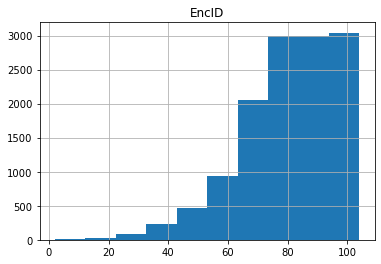

In [787]:
# distribution of total number of vital records per person
encid_count.hist()

In [911]:
not_die_few_rec[not_die_few_rec['total_vital_records']<20]

,total_vital_records
118_P10,2
238_P10,2
57_P10,3
46279803_P09,5
24166_P02,6
...,...
46216738_P09,18
10341_P03,18
46220527_P09,18
1156_P03,19


In [925]:
# confirm death time of patients who have few records but did not die
few_rec = new_df[new_df['EncID'].isin(not_die_few_rec[not_die_few_rec['total_vital_records']<20].index)]
few_rec_full = pd.merge(few_rec,not_die_few_rec, how= 'left',left_on="EncID" , right_index= True).sort_values(by=['total_vital_records','EncID','event_hour'])
few_rec['EncID'].nunique()

18

In [922]:
pd.set_option('display.max_rows', None)
few_rec_full.drop(['mods_day7','died_in_hosp','event_value'],axis = 1)

,EncID,event_hour,event_name,hospital_id,age_group,died_hour_round,event_value_norm,total_vital_records
715899,118_P10,9.0,FIO2,P10,144 to 216 mo,NaN,-1.254624,2
715900,118_P10,12.0,FIO2,P10,144 to 216 mo,NaN,-1.254624,2
98194,238_P10,0.0,PULSE,P10,144 to 216 mo,NaN,-0.703209,2
877193,238_P10,0.0,PULSE_OX,P10,144 to 216 mo,NaN,-0.109636,2
133434,57_P10,4.0,PULSE,P10,144 to 216 mo,NaN,-2.106412,3
567299,57_P10,4.0,RESP_RATE,P10,144 to 216 mo,NaN,-0.224968,3
668907,57_P10,4.0,TEMP,P10,144 to 216 mo,NaN,-0.366914,3
272556,46279803_P09,12.0,MAP,P09,2 to 11 mo,NaN,0.160281,5
128846,46279803_P09,12.0,PULSE,P09,2 to 11 mo,NaN,-0.805964,5
907559,46279803_P09,12.0,PULSE_OX,P09,2 to 11 mo,NaN,0.134269,5


These IDs will have too much imputation and will be removed from the imputed dataset

## After Death Records

In [790]:
# get those with event hours greater than death hour
pd.set_option('display.max_rows', 10)
dead_12hr_full = new_df[new_df['EncID'].isin(death_time_id['EncID'].tolist())]
dead_12hr_full['event_after_death_time_diff'] = np.where((dead_12hr_full['event_hour'] > dead_12hr_full['died_hour_round']), dead_12hr_full['event_hour']-dead_12hr_full['died_hour_round'], 'NA')

<ipython-input-790-8d622a7daea2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dead_12hr_full['event_after_death_time_diff'] = np.where((dead_12hr_full['event_hour'] > dead_12hr_full['died_hour_round']), dead_12hr_full['event_hour']-dead_12hr_full['died_hour_round'], 'NA')


In [871]:
dead_12hr_full['EncID'].nunique()

119

In [874]:
# subsetting to only columns of interest
event_after_death = dead_12hr_full[dead_12hr_full['event_after_death_time_diff']!='NA' ][['EncID','hospital_id','age_group','event_name','event_value','event_hour','died_hour_round','event_after_death_time_diff']]
event_after_death

,EncID,hospital_id,age_group,event_name,event_value,event_hour,died_hour_round,event_after_death_time_diff
210666,14041 L2_P01,P01,12 to 24 mo,MAP,83.000000,1.0,0.0,1.0
59643,14041 L2_P01,P01,12 to 24 mo,PULSE,174.000000,1.0,0.0,1.0
838901,14041 L2_P01,P01,12 to 24 mo,PULSE_OX,100.000000,1.0,0.0,1.0
496160,14041 L2_P01,P01,12 to 24 mo,RESP_RATE,45.000000,1.0,0.0,1.0
352024,14041 L2_P01,P01,12 to 24 mo,SBP,113.000000,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...
881623,2593_P13,P13,24 to 59 mo,PULSE_OX,97.800000,12.0,1.0,11.0
538176,2593_P13,P13,24 to 59 mo,RESP_RATE,25.000000,12.0,1.0,11.0
391347,2593_P13,P13,24 to 59 mo,SBP,114.444444,12.0,1.0,11.0
997507,2593_P13,P13,24 to 59 mo,SF_RATIO,244.500000,12.0,1.0,11.0


In [792]:
# number of patients who have events after death
event_after_death['EncID'].nunique()

37

In [793]:
# event-death hour difference event count
event_after_death['event_after_death_time_diff'].value_counts().head(10)

2.0     232
1.0     224
3.0     198
4.0     179
5.0     142
6.0     105
7.0      94
8.0      85
9.0      60
10.0     43
Name: event_after_death_time_diff, dtype: int64

In [795]:
# extract id and last vital
event_after_death = event_after_death.sort_values(by = ['EncID','event_hour'],ascending=True)
new_death_time_for_dead = event_after_death.groupby('EncID').last()['event_hour'].tolist()
id_for_dead = event_after_death['EncID'].unique().tolist()

In [796]:
# replace old death time with last vital time
for idx,val in enumerate(id_for_dead):
    new_df.loc[new_df['EncID'] ==val, 'died_hour_round'] = new_death_time_for_dead[idx]

In [797]:
# confirm no more event hour after death
tmp = np.where((new_df['event_hour'] > new_df['died_hour_round']), new_df['event_hour']-new_df['died_hour_round'], 'NA')
[i for i in tmp if i !='NA']

[]

In [798]:
new_df.to_csv('vitals_trajectory_cleaned.csv',index=False)

## imputed data check

In [928]:
imp = pd.read_csv('vitals_trajectory_imputed.csv')
imp = imp.drop('Unnamed: 0', axis = 1)
imp

,EncID,event_hour,hospital_id,age_group,mods_day7,died_in_hosp,died_hour_round,FIO2Imputed,MAPImputed,PULSEImputed,PULSE_OXImputed,RESP_RATEImputed,SBPImputed,SF_RATIOImputed,TEMPImputed
0,10236 L2_P01,0,P01,1 mo,0,0,NaN,-0.728507,0.249764,0.772329,0.108161,0.573058,0.455669,0.588251,-0.132192
1,10236 L2_P01,1,P01,1 mo,0,0,NaN,-0.728507,0.064598,1.069369,0.108161,0.094031,0.107226,0.588251,0.408066
2,10236 L2_P01,2,P01,1 mo,0,0,NaN,-0.621291,0.591607,0.973106,0.495734,-0.155462,0.293062,0.435020,0.678195
3,10236 L2_P01,3,P01,1 mo,0,0,NaN,-0.514075,0.021868,1.193135,0.108161,-0.280208,0.176915,0.188200,0.948324
4,10236 L2_P01,4,P01,1 mo,0,0,NaN,-0.406859,0.192790,0.986858,0.274264,-0.280208,-0.101839,0.051275,0.828268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166941,986_P13,8,P13,60 to 143 mo,0,0,NaN,0.247069,1.795330,-0.970044,0.741121,-1.287351,1.546742,-0.639474,-0.302156
166942,986_P13,9,P13,60 to 143 mo,0,0,NaN,0.247069,2.537591,-1.456137,0.232641,-0.750075,2.380789,-0.670668,-0.324022
166943,986_P13,10,P13,60 to 143 mo,0,0,NaN,0.247069,2.205526,-1.140177,0.614001,-0.321706,1.948002,-0.647272,-0.345888
166944,986_P13,11,P13,60 to 143 mo,0,0,NaN,0.247069,1.761147,-1.121273,-0.021599,-0.677470,1.637026,-0.686265,-0.345888


In [896]:
imp['EncID'].nunique()

12842

In [897]:
imp[['FIO2Imputed','MAPImputed','PULSEImputed','PULSE_OXImputed','RESP_RATEImputed','SBPImputed','SF_RATIOImputed','TEMPImputed']].isna().sum()

FIO2Imputed         418
MAPImputed          418
PULSEImputed        418
PULSE_OXImputed     418
RESP_RATEImputed    418
SBPImputed          418
SF_RATIOImputed     418
TEMPImputed         418
dtype: int64

In [924]:
#pd.set_option('display.max_rows', 10)
imp_dead[imp_dead['event_hour']>imp_dead['died_hour_round']]

,EncID,event_hour,hospital_id,age_group,mods_day7,died_in_hosp,died_hour_round,FIO2Imputed,MAPImputed,PULSEImputed,PULSE_OXImputed,RESP_RATEImputed,SBPImputed,SF_RATIOImputed,TEMPImputed
684,14041 L2_P01,8,P01,12 to 24 mo,1,1,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
685,14041 L2_P01,9,P01,12 to 24 mo,1,1,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
686,14041 L2_P01,10,P01,12 to 24 mo,1,1,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
687,14041 L2_P01,11,P01,12 to 24 mo,1,1,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688,14041 L2_P01,12,P01,12 to 24 mo,1,1,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166616,78_P13,8,P13,60 to 143 mo,1,1,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166617,78_P13,9,P13,60 to 143 mo,1,1,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166618,78_P13,10,P13,60 to 143 mo,1,1,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166619,78_P13,11,P13,60 to 143 mo,1,1,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [898]:
imp_dead = imp[imp['EncID'].isin(dead_12hr_full['EncID'].tolist())]
imp_dead[imp_dead['event_hour']>imp_dead['died_hour_round']]['EncID'].nunique()

82

In [899]:
imp[imp['died_hour_round'] <13]['EncID'].nunique()

119

In [885]:
119-82

37

matches up with prior result, 37 = the number who have events past death, so they have full records until death

In [900]:
imp.groupby('age_group')[['FIO2Imputed','MAPImputed','PULSEImputed','PULSE_OXImputed','RESP_RATEImputed','SBPImputed','SF_RATIOImputed','TEMPImputed']].mean().round(2)

,FIO2Imputed,MAPImputed,PULSEImputed,PULSE_OXImputed,RESP_RATEImputed,SBPImputed,SF_RATIOImputed,TEMPImputed
age_group,,,,,,,,
1 mo,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0
12 to 24 mo,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0
144 to 216 mo,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
2 to 11 mo,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0
24 to 59 mo,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0
60 to 143 mo,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0


In [929]:
# removing 18 IDs who have a lot of imputed values
imp_clean = imp[~imp['EncID'].isin(few_rec['EncID'].unique().tolist())]

In [931]:
imp_clean.to_csv('vitals_trajectory_imputed_no_unimputable.csv',index=False)